In [2]:
from functools import reduce

import os
import jax
import jax.numpy as jnp
from imax import transforms
import matplotlib.pyplot as plt

from PIL import Image
from jmd_imagescraper.core import *
from jmd_imagescraper.imagecleaner import *
from jax.random import PRNGKey as jkey
from flax.training.train_state import TrainState as RawTrainState
from chex import Array, Shape, Scalar, PRNGKey

from training_gan import initialize_GAN, plot_samples

## Dataset Creation
### Download mushrooms from *DuckDuckGo*

In [3]:
root = "datasets"
duckduckgo_search(root, "amanita", "fly agaric", max_results=240, img_color=ImgColor.Red)
display_image_cleaner(root)

Duckduckgo search: fly agaric


HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

### Load mushrooms from drive

In [4]:
PARENT_DIR = "datasets/amanita_raw"

files = os.listdir("datasets/amanita_raw")

load_galaxy = lambda file: jnp.array(Image.open(os.path.join(PARENT_DIR, file)).resize((64, 64)))

images = jnp.array(list(map(load_galaxy, files)))
images.shape

(176, 64, 64, 3)

### Get rid of repetitions

In [5]:
no_images = images.shape[0]

repetitions_dict = dict()
for original_idx in range(no_images - 1):
    for susspect_idx in range(original_idx + 1, no_images):
        if jnp.array_equal(images[susspect_idx], images[original_idx]):
            if original_idx in repetitions_dict.keys():
                repetitions_dict[original_idx].append(susspect_idx)
            else:
                repetitions_dict[original_idx] = [susspect_idx]

In [6]:
repetitions_set = set(reduce(lambda x, y: x + y, repetitions_dict.values(), []))
unique_indeces = set(range(no_images)).difference(repetitions_set)
unique_images = images[jnp.array(list(unique_indeces))]
unique_images.shape

(151, 64, 64, 3)

### Augment data

In [10]:
# def augmentat_img(img, key: PRNGKey):

#     key_1, key_2, key_3, key_4, key_5, key_6 = jax.random.split(key, 6)

#     rot = transforms.rotate(
#         rad=jax.random.uniform(key_1, minval=-jnp.pi / 8, maxval=jnp.pi / 8)
#     )
#     flip = transforms.flip(
#         jax.random.uniform(key_2) < 0.5,
#         jax.random.uniform(key_3) < 0.5
#     )
#     scale = transforms.scale(
#         jax.random.uniform(key_4, minval=1.0, maxval=1.5),
#         jax.random.uniform(key_4, minval=1.0, maxval=1.5)
#     )
#     translate = transforms.translate(
#         jax.random.uniform(key_5, minval=-8.0, maxval=8.0),
#         jax.random.uniform(key_6, minval=-8.0, maxval=8.0)
#     )

#     return transforms.apply_transform(img, flip @ rot @ translate @ scale, mask_value=-1)


def augmentat_img(img, key: PRNGKey):

    key_1, key_2, key_3, key_4, key_5, key_6 = jax.random.split(key, 6)

    rot = transforms.rotate(
        rad=jax.random.uniform(key_1, minval=-jnp.pi / 16, maxval=jnp.pi / 16)
    )
    flip = transforms.flip(
        horizontal=jax.random.uniform(key_2) < 0.5,
        vertical=False
    )
    scale = transforms.scale(
        jax.random.uniform(key_4, minval=1.0, maxval=1.25),
        jax.random.uniform(key_4, minval=1.0, maxval=1.25)
    )
    translate = transforms.translate(
        jax.random.uniform(key_5, minval=-4.0, maxval=4.0),
        jax.random.uniform(key_6, minval=-4.0, maxval=4.0)
    )

    return transforms.apply_transform(img, flip @ rot @ translate @ scale, mask_value=-1)

In [11]:
def augment_dataset(key: PRNGKey, dataset: Array, rate: Scalar, dir_path: str, label: str, ext: str = "png"):
    
    reps = int(rate // 1)
    prob = rate % 1

    key, uniform_key = jax.random.split(key)

    counter = 1
    probs = jax.random.uniform(uniform_key, shape=(dataset.shape[0],))
    for img_idx, img in enumerate(dataset):

        plt.imsave(
            os.path.join(dir_path, f"{label}_{counter}.{ext}"),
            img
        )
        counter += 1

        for i in range(reps):
            key, augment_key = jax.random.split(key)
            plt.imsave(
                os.path.join(dir_path, f"{label}_{counter}.{ext}"),
                augmentat_img(img, augment_key[i])
            )
            counter += 1
        
        if probs[img_idx] < prob:
            key, augment_key = jax.random.split(key)
            plt.imsave(
                os.path.join(dir_path, f"{label}_{counter}.{ext}"),
                augmentat_img(img, augment_key[-1])
            )
            counter += 1

In [12]:
# augment_dataset(jkey(21335), unique_images, rate=3, dir_path="datasets/amanita", label="amanita")

## Simple Dataset Creation
### Create the image we aim to reproduce with GAN

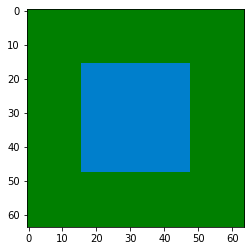

In [12]:
# simple_img = jnp.ones((64, 64, 3)) * 0.25
# simple_img = simple_img.at[6:24, 6:24, 0].set(0.8)
# simple_img = simple_img.at[48:60, 48:60, 1].set(0.7)
# simple_img = simple_img.at[16:40, 16:40, 2].set(0.7)

simple_img = jnp.zeros((64, 64, 3))
simple_img = simple_img.at[:, :, 1].set(0.5)
simple_img = simple_img.at[16:48, 16:48, 2].set(0.8)

plt.imshow(simple_img);

### Apply random noise to the pattern

In [13]:
ds_size = 100
noise_ratio = 0.1

@jax.jit
def get_noise(state_gen: RawTrainState, batch_vector: Array):

    noise = state_gen.apply_fn(
        {'params': state_gen.params},
        batch_vector
    )

    return noise

_, _, state_gen = initialize_GAN()
dummy_batch_vector = jax.random.normal(jkey(44), shape=(ds_size, 128)) * 25
noise = get_noise(state_gen, dummy_batch_vector)
ds_simple = noise_ratio * noise + (1 - noise_ratio) * simple_img
ds_simple *= 255
ds_simple = ds_simple.astype(jnp.uint8)

### Augment and save dataset

In [15]:
# augment_dataset(jkey(42), ds_simple, rate=0, dir_path="datasets/simple", label="img")

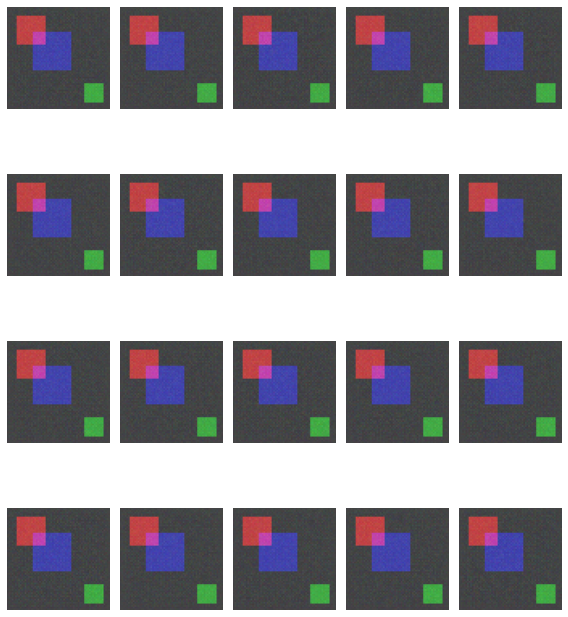

In [ ]:
# plot_samples(ds_simple, subplots_shape=(4, 5))